# BERT Trainer

<hr>

### Imports

In [2]:
import pandas as pd
import matplotlib as plt

In [3]:
import torch
import transformers
import numpy as np
from transformers import BertTokenizer

In [4]:
from torch import nn
from transformers import BertModel
from torch.optim import Adam
from tqdm import tqdm

### Reading the data

In [ ]:
datapath = 'data/bbc-text.csv'

In [5]:
df = pd.read_csv(datapath)
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


<AxesSubplot:xlabel='category'>

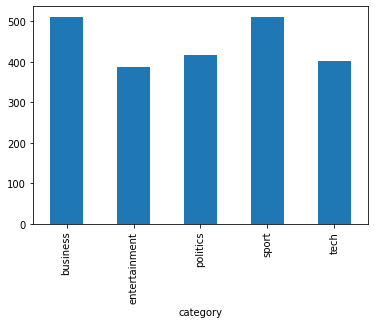

In [6]:
df.groupby(['category']).size().plot.bar()

### Preparing the data

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

example_text = 'I will watch Memento tonight'
bert_input = tokenizer(example_text, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824,  2508, 26173,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


In [8]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] I will watch Memento tonight [SEP] [PAD] [PAD]


In [11]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text, padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [57]:
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          }

In [13]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [14]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [15]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

In [30]:
EPOCHS = 4
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [1:02:51<00:00,  4

Epochs: 1 | Train Loss:  0.742                 | Train Accuracy:  0.388                 | Val Loss:  0.554                 | Val Accuracy:  0.716


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [1:02:05<00:00,  4.19s/it]


Epochs: 2 | Train Loss:  0.319                 | Train Accuracy:  0.907                 | Val Loss:  0.165                 | Val Accuracy:  0.977


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [56:49<00:00,  3.83s/it]


Epochs: 3 | Train Loss:  0.131                 | Train Accuracy:  0.976                 | Val Loss:  0.084                 | Val Accuracy:  0.995


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [55:21<00:00,  3.73s/it]


Epochs: 4 | Train Loss:  0.073                 | Train Accuracy:  0.987                 | Val Loss:  0.051                 | Val Accuracy:  0.991


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 890/890 [1:04:50<00:00,  4.37s/it]


Epochs: 5 | Train Loss:  0.043                 | Train Accuracy:  0.996                 | Val Loss:  0.036                 | Val Accuracy:  0.995


In [23]:
def evaluate(model, test_data):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:
              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)
              output = model(input_id, mask)
              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

> /tmp/ipykernel_9562/3190260024.py(3)evaluate()
      1 def evaluate(model, test_data):
      2     import pdb; pdb.set_trace()
----> 3     test = Dataset(test_data)
      4     test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
      5     use_cuda = torch.cuda.is_available()

ipdb> n
> /tmp/ipykernel_9562/3190260024.py(4)evaluate()
      2     import pdb; pdb.set_trace()
      3     test = Dataset(test_data)
----> 4     test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
      5     use_cuda = torch.cuda.is_available()
      6     device = torch.device("cuda" if use_cuda else "cpu")

ipdb> n
> /tmp/ipykernel_9562/3190260024.py(5)evaluate()
      3     test = Dataset(test_data)
      4     test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
----> 5     use_cuda = torch.cuda.is_available()
      6     device = torch.device("cuda" if use_cuda else "cpu")
      7     if use_cuda:

ipdb> n
> /tmp/ipykernel_9562/3190260024.py(6)evaluate()
      4

ipdb> n
> /tmp/ipykernel_9562/3190260024.py(15)evaluate()
     13         for test_input, test_label in test_dataloader:
     14               test_label = test_label.to(device)
---> 15               mask = test_input['attention_mask'].to(device)
     16               input_id = test_input['input_ids'].squeeze(1).to(device)
     17               output = model(input_id, mask)

ipdb> test_label
tensor([4, 4])
ipdb> device
device(type='cpu')
ipdb> input_id
*** NameError: name 'input_id' is not defined
ipdb> n
> /tmp/ipykernel_9562/3190260024.py(16)evaluate()
     14               test_label = test_label.to(device)
     15               mask = test_input['attention_mask'].to(device)
---> 16               input_id = test_input['input_ids'].squeeze(1).to(device)
     17               output = model(input_id, mask)
     18               acc = (output.argmax(dim=1) == test_label).sum().item()

ipdb> n
> /tmp/ipykernel_9562/3190260024.py(17)evaluate()
     15               mask = test_input['a

### Saving Model

In [32]:
# torch.save(model, 'models/basic_bert.bin')

### Loading from a saved model

In [19]:
model = torch.load('models/basic_bert.bin')

In [24]:
df_test

,category,text
1154,politics,chancellor rallies labour voters gordon brown ...
207,politics,blair to face trust issue head on tony blair s...
2219,business,beijingers fume over parking fees choking traf...
1682,politics,blair rejects iraq advice calls tony blair has...
1122,business,turkey knocks six zeros off lira turkey is to ...
...,...,...
1638,sport,a november to remember last saturday one news...
1095,sport,african double in edinburgh world 5000m champi...
1130,tech,what price for trusted pc security you can ...
1294,sport,o driscoll/gregan lead aid stars ireland s bri...


In [69]:
def get_prediction(some_text, model):
    bert_input = tokenizer(some_text, padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    if use_cuda:
        model = model.cuda()

    with torch.no_grad():
        mask = bert_input['attention_mask'].to(device)
        input_id = bert_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
    
    print(output.argmax(dim=1))
    return output.argmax(dim=1), output

In [81]:
result, full_op = get_prediction(df.loc[5][1], model)

tensor([0])


In [82]:
full_op

tensor([[0.6994, 0.0000, 0.0000, 0.4855, 0.0693]])

In [83]:
df.loc[3]

category                                                sport
text        yeading face newcastle in fa cup premiership s...
Name: 3, dtype: object

In [84]:
reverse_map = {v:k for k, v in labels.items()}
print(reverse_map[int(result)], reverse_map)

business {0: 'business', 1: 'entertainment', 2: 'sport', 3: 'tech', 4: 'politics'}


In [86]:
print(df.loc[5][0], "\n", df.loc[5][1])

politics 
 howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an  attack mongrel  shows labour is  rattled  by the opposition.  in an upbeat speech to his party s spring conference in brighton  he said labour s campaigning tactics proved the tories were hitting home. mr hain made the claim about tory tactics in the anti-terror bill debate.  something tells me that someone  somewhere out there is just a little bit rattled   mr howard said. mr hain  leader of the commons  told bbc radio four s today programme that mr howard s stance on the government s anti-terrorism legislation was putting the country at risk. he then accused the tory leader of behaving like an  attack mongrel  and  playing opposition for opposition sake .  mr howard told his party that labour would  do anything  say anything  claim anything to cling on to office at all costs .  so far this year they have compared me to fagin  to shylock and to a flying pig